![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---

# CNNs con MNIST
En prácticas anteriores hemos visto como se desempeña una red neuronal simple o MLP con el <a href='https://en.wikipedia.org/wiki/MNIST_database'>dataset MNIST </a>. Vamos a trabajar con esos mismos datos pero configurando una <a href='https://en.wikipedia.org/wiki/Convolutional_neural_network'>Red Neuronal Convolucional o Convolutional Neural Network</a> (CNN).

Para el desarrollo de esta red, hemos de tener claros los conceptos de:
* capas convolucionales
* filtros/kernels
* pooling
* profundidad/canales, stride y padding

Observa que en este ejercicio no será necesario extender (flatten) los datos ya que una red convolucional maneja datos en 2D.

## Importaciones

In [113]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Carga del dataset MNIST

PyTorch pone a disposición los conjuntos de train y test en <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>. La primera vez que es llamado, el dataset es descargado en el equipo local, al directorio especificado. Desde entonces, torchvision siempre busca una copia local, antes de descargar los datos.

En notebooks anteriores ya trabajamos las tranformaciones, tamaño de batch y el <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><tt><strong>DataLoader</strong></tt></a>.

In [114]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [115]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [116]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

### Creamos los loaders (*cargadores* de datos)
Cuando trabajamos con imagenes, lo haremos con lotes relativamente pequeños, un tamaño de lote de 4-10 no es algo raro.

In [117]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

## Definimos el modelo convolucional
En los modelos anteriores usamos únicamente capas totalmente conectadas, con una entrada de 784 (imagennes "flattened" desde 28x28), capas ocultas de 120 y 84 neuronas, y un tamaño de salida de 10 representando los 10 posibles digitos.

En este caso emplearemos dos capas convolucionales y dos capas de pooling antes de conectar los datos a través de algunas capas ocultas totalmente conectadas y finalmente a la capa de salida.

El modelo tendrá la arquitectura: CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC.

<div class="alert alert-info"><strong>Vamos a detallar los pasos que seguiremos</strong><br>

1. Extendemos la clase base  Module:
   
<tt><font color=black>class ConvolutionalNetwork(nn.Module):<br>
&nbsp;&nbsp;&nbsp;&nbsp;def \_\_init\_\_(self):<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;super().\_\_init\_\_()</font></tt><br>

2. Configuramos las capas convolucionales con <a href='https://pytorch.org/docs/stable/nn.html#conv2d'><tt><strong>torch.nn.Conv2d()</strong></tt></a><br><br>
La primera capa solo tiene un canal de entrada (canal de escala de grises, la imagen es en B/N). Asignaremos 6 canales de salida en esa convolucion para la extracción de caraterísticas. Configuramos un tamaño de kernel de 3 y hacemos un filtro de 3x3, poniendo un tamaño de paso (stride) igual a 1.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.conv1 = nn.Conv2d(1, 6, 3, 1)</font></tt><br>
En la segunda capa tomamos los 6 canales de entrada y preparamos 16 de salida..<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.conv2 = nn.Conv2d(6, 16, 3, 1)</font></tt><br><br>

3. Configuramos las capas totalmente conectadas (FC) con <a href='https://pytorch.org/docs/stable/nn.html#linear'><tt><strong>torch.nn.Linear()</strong></tt></a>.<br><br>
El tamaño será (5x5x16) y está determinado por el efecto de los kernel, el stride y el tamaño de la imagen de entrada. Un filtro 3x3 aplicado a una imagen de 28x28 se "come" un borde de 1-pixel en cada una de las 4 caras. En una capa, el tamaño pasa de 28x28 a 26x26. Podríamos solucionar esto con zero-padding, pero dado que una imagen MNIST es mayoritariamente negra en los bordes, podemos ignorar esos píxels con tranquilidad. Vamos a aplicar esos filtros dos veces, así como las capas de pooling, por lo que el resultado final será
$\;(((28-2)/2)-2)/2 = 5.5\;$ que redondearemos hacia abajo a 5 pixels por cara.<br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc1 = nn.Linear(5\*5\*16, 120)</font></tt><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc2 = nn.Linear(120, 84)</font></tt><br>
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;self.fc3 = nn.Linear(84, 10)</font></tt><br>

4. Definimos el método forward().<br><br>
Las activaciones se aplican a las convoluciones en una sola línea usando <a href='https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU'><tt><strong>F.relu()</strong></tt></a> y el pooling se realiza con <a href='https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d'><tt><strong>F.max_pool2d()</strong></tt></a><br>

<tt><font color=black>def forward(self, X):<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.conv1(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.max_pool2d(X, 2, 2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.conv2(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.max_pool2d(X, 2, 2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;</font></tt># Extendemos los datos para las capas FC:<br><tt><font color=black>
&nbsp;&nbsp;&nbsp;&nbsp;X = X.view(-1, 5\*5\*16)<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = F.relu(self.fc1(X))<br>
&nbsp;&nbsp;&nbsp;&nbsp;X = self.fc2(X)<br>
&nbsp;&nbsp;&nbsp;&nbsp;return F.log_softmax(X, dim=1)</font></tt>
</div>

<div class="alert alert-danger"><strong>Desglosando las capas convolucionales</strong> (este código es únicamente con fines ilustrativos.)</div>

In [118]:
# Define layers
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [119]:
# Grab the first MNIST record
for i, (X_train, y_train) in enumerate(train_data):
    break

In [120]:
# Create a rank-4 tensor to be passed into the model
# (train_loader will have done this already)
x = X_train.view(1,1,28,28)
print(x.shape)

torch.Size([1, 1, 28, 28])


In [121]:
# Perform the first convolution/activation
x = F.relu(conv1(x))
print(x.shape)

torch.Size([1, 6, 26, 26])


In [122]:
# Run the first pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 6, 13, 13])


In [123]:
# Perform the second convolution/activation
x = F.relu(conv2(x))
print(x.shape)

torch.Size([1, 16, 11, 11])


In [124]:
# Run the second pooling layer
x = F.max_pool2d(x, 2, 2)
print(x.shape)

torch.Size([1, 16, 5, 5])


In [125]:
# Flatten the data
x = x.view(-1, 5*5*16)
print(x.shape)

torch.Size([1, 400])


<div class="alert alert-danger"><strong>Así es como la salida de la convolución es pasada a la capas totalmente conectadas FC.</strong></div>

Preparamos ahora el código completo.

In [126]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [127]:
torch.manual_seed(42)
# model = ConvolutionalNetwork().cuda()
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Incluyendo el bias para cada capa, el número total de parámetros entrenables que va a tener la red es:<br>

$\quad\begin{split}(1\times6\times3\times3)+6+(6\times16\times3\times3)+16+(400\times120)+120+(120\times84)+84+(84\times10)+10 &=\\
54+6+864+16+48000+120+10080+84+840+10 &= 60,074\end{split}$<br>

In [128]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [129]:
count_parameters(model)

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


## Definimos función de pérdida y optimizador

Podemos ver la documentacion de funciones de pérdida [aquí](https://pytorch.org/docs/stable/nn.html#loss-functions).

Podemos ver la documentación sobre optimizadores [aquí](https://pytorch.org/docs/stable/optim.html).

In [130]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [131]:
torch.cuda.current_device()

0

In [132]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

## Entrenamos el modelo
Los datos son suministrados directamente al modelo sin necesidad de "flattening"

In [133]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        # Apply the model
        # X_train = X_train.cuda()
        # y_train = y_train.cuda()
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # X_test = X_test.cuda()
            # y_test = y_test.cuda()

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  600 [  6000/60000]  loss: 0.04255063  accuracy:  78.483%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.07605956  accuracy:  85.825%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.30995855  accuracy:  88.667%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.02058033  accuracy:  90.479%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00755560  accuracy:  91.620%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.00184915  accuracy:  92.478%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.48222557  accuracy:  93.117%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.03378323  accuracy:  93.573%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.01340340  accuracy:  93.989%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.05054053  accuracy:  94.283%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.02433738  accuracy:  97.817%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.02778601  accuracy:  97.833%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.00168820  accuracy:  97.928%
epoch:  1  b

## Graficamos pérdida (loss) y precision (accuracy) para comparar

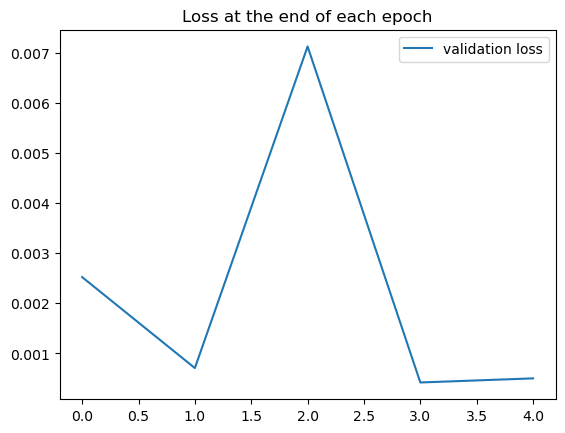

In [136]:
# (plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [137]:
test_losses

[tensor(0.0025),
 tensor(0.0007),
 tensor(0.0071),
 tensor(0.0004),
 tensor(0.0005)]

Aunque puede haber algo de sobreentrenamiento, este es bastante menor que en el modelo de RNA FC.

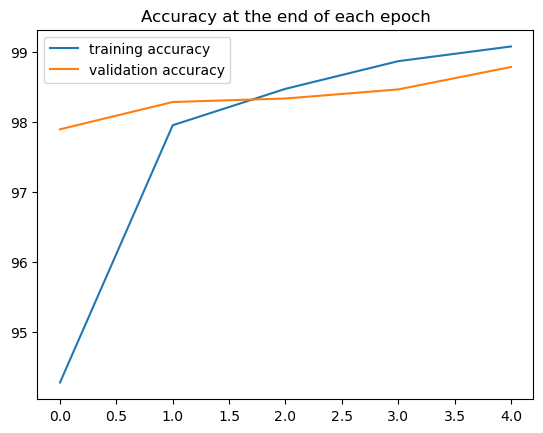

In [138]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

## Evaluamos Test Data

In [139]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [140]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9879/10000 =  98.790%


Recordemos que una RNA FC [784,120,84,10]obtuvo un accuracy de 97.25% depués de 10 epochs. Y requirió 105.214 parametros frente a la actual de 60.074 parámetros.

## Visualizamos la matriz de confusión


In [141]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 974    0    0    0    0    1    3    0    4    1]
 [   1 1135    2    1    0    0    5    9    0    0]
 [   0    0 1017    0    1    0    0    3    0    0]
 [   0    0    1  999    0    7    0    0    1    1]
 [   0    0    1    0  976    0    1    1    1   12]
 [   0    0    0    5    0  878    5    0    1    3]
 [   4    0    0    0    4    2  943    0    2    0]
 [   1    0    6    4    0    1    0 1012    1    4]
 [   0    0    5    1    0    1    1    1  962    5]
 [   0    0    0    0    1    2    0    2    2  983]]


## Examinamos los fallos
Podemos seguir los índices de las predicciones fallidas, y extraer la correspondiente imagen y etiqueta. Lo haremos en batches para ahorrar espacio en la pantalla

In [142]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')

# Display the number of misses
len(misses)

121

In [143]:
# Display the first 10 index positions
misses[:10]

array([  18,  247,  320,  321,  340,  359,  445,  449,  495,  720])

In [144]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Hemos configurado un iterador (row) y ahora podemos lanzar y relanzar la celda siguiente para ir moviendonos por todas las predicciones fallidas.
<br>
Puedes usar <kbd>Ctrl+Enter</kbd> para mantenerte en la misma celda entre ejecuciones. Verás un <tt>StopIteration</tt> una vez que todos los fallos hayan sido mostrados.

Index: [1242 1247 1260 1299 1319 1393 1414 1522 1549 1553 1681]
Label: [   4    9    7    5    8    5    9    7    4    9    3]
Guess: [   9    5    1    7    0    3    4    1    6    3    7]


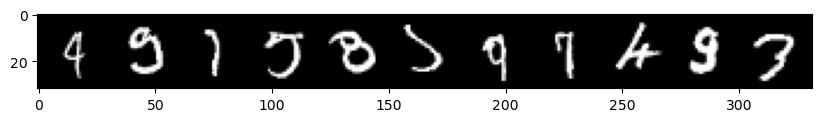

In [149]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Pasar una nueva muestra al modelo
Lógicamente, también podemos pasar una sola imagen por el modelo para obtener una predicción.
Elige un número del 0 al 9999, asígnalo a "x" y utilizaremos ese valor para seleccionar un número del conjunto de pruebas MNIST.

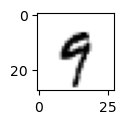

In [146]:
x = 2019
plt.figure(figsize=(1,1))
plt.imshow(test_data[x][0].reshape((28,28)), cmap="gist_yarg");

In [147]:
model.eval()
with torch.no_grad():
    new_pred = model(test_data[x][0].view(1,1,28,28)).argmax()
print("Predicted value:",new_pred.item())

Predicted value: 9


## Fin del Notebook

Referencias y modelos empleados para el Notebook:

*   Documentación de [Pytorch](https://pytorch.org/docs/stable/index.html)
*   [PyTorch Tutorial for Deep Learning Researchers](https://github.com/yunjey/pytorch-tutorial) by Yunjey Choi
*   [FastAI](https://www.fast.ai/) development notebooks by Jeremy Howard.
*   Documentación y cursos en [Pierian Data](https://www.pieriandata.com/)